## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
import h5py
from scipy.integrate import quadrature
import pickle

import warnings

warnings.filterwarnings('ignore')

In [2]:
# h5pydir = '/Users/nolansmyth/Dropbox/kinetic_recoupling/h5py_dat/'
h5pydir = 'h5py_dat/'

# h5pydir = '<YOUR PATH HERE>Dropbox/kinetic_recoupling/h5py_dat/'

In [3]:
plt.style.use("/Users/nolansmyth/Dropbox/kinetic_recoupling/figures/style.mplstyle")
# plt.style.use("<YOUR PATH HERE>Dropbox/kinetic_recoupling/figures/style.mplstyle")

## Parameters and Constants

In [42]:
spline_pars = {'k': 3, 's': 0.0}

z_pk = 0.0; #redshift at which Pk is determined
pk_max = 1.e2; #maximum k for Pk
kk = np.logspace(-4,np.log10(pk_max),500)
f_idm_dr = 1.0
omega0_cdm = 0.12038;
xi = 0.3
# BM_KS = ['10']
# BM_KS = [str(round(n,1)) for n in np.geomspace(1, 10, 5)]
BM_KS = [str(round(n,1)) for n in np.geomspace(1, 10, 5)]


# A_recs = [1e8, 1e10, 1e12, 1e14, 1e16, 1e18]
A_recs = [1e11, 1e12, 1e14]
# A_recs = [1e11]


T_rec = 6.0e5
# k = 10 #use one k mode for now


In [43]:
BM_KS

['1.0', '1.8', '3.2', '5.6', '10.0']

## Functions

In [6]:
def scientific_format(x):
    s = '%.1e' % x
    mantissa, exponent = s.split('e')
    return r'${} \times 10^{{{}}}$'.format(mantissa, int(exponent))    

## Read in h5py files

In [79]:
k = BM_KS[0]

In [80]:
k

'1.0'

In [81]:
#Get data for case with no recoupling
data_file=h5pydir+'class_testing_no_rec.hdf5'
with h5py.File(data_file, 'r') as f:
    tau_data = np.array(f['scalar']['k='+str(k)]['tau [Mpc]'])
    delta_chi_data = np.array(f['scalar']['k='+str(k)]['delta_idm_dr'])
    phi_data = np.array(f['scalar']['k='+str(k)]['phi'])
    theta_dr_data = np.array(f['scalar']['k='+str(k)]['theta_idr'])
    theta_data = np.array(f['scalar']['k='+str(k)]['theta_idm_dr'])
    
    delta_chi_no_rec = UnivariateSpline(tau_data, delta_chi_data, **spline_pars)
    delta_chi_dot_no_rec = delta_chi_no_rec.derivative()
    phi_no_rec = UnivariateSpline(tau_data, phi_data, **spline_pars)
    phi_dot_no_rec = phi_no_rec.derivative()
    theta_dr_no_rec = UnivariateSpline(tau_data, theta_dr_data, **spline_pars)

    theta_chi_no_rec = UnivariateSpline(tau_data, theta_data, **spline_pars)
    theta_chi_dot_no_rec = theta_chi_no_rec.derivative()

    Pks_no_rec = np.array(f['power_spectrum']['Pk'])
    kks_no_rec = np.array(f['power_spectrum']['kk'])

    kappa_dot_data_no_rec = np.flip(np.array(f['thermodynamics']['dmu_idm_dr']))
    z_data_no_rec = np.flip(np.array(f['thermodynamics']['z']))

    rho_idr_no_rec = np.array(f['background']['(.)rho_idr'])
    rho_idm_no_rec = np.array(f['background']['(.)rho_idm_dr'])
    bkg_zs_no_rec = np.array(f['background']['z'])

In [108]:
data_file=h5pydir+'class_testing_no_rec.hdf5'
with h5py.File(data_file, 'r') as f:
    clTT = np.array(f['cmb']['tt'])
    ll = np.array(f['cmb']['ell'])
    clEE = np.array(f['cmb']['ee'])
    clPP = np.array(f['cmb']['pp'])

In [111]:
lensed_cls = LambdaCDM.lensed_cl(2500)
lambda_clTT = lensed_cls['tt']
lambda_ll = lensed_cls['ell']
lambda_clEE = lensed_cls['ee']
lambda_clPP = lensed_cls['pp']

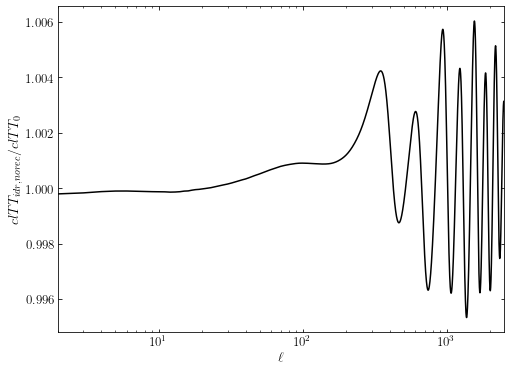

In [118]:
plt.xscale('log');plt.yscale('linear');plt.xlim(2,2500)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$clTT_{idr, no rec}/clTT_{0}$')
plt.plot(lambda_ll,clTT/lambda_clTT,'k-')

In [72]:
# H_interp = pickle.load(open('interps/H_interp.p','rb')) #H(z)

# H_interp = UnivariateSpline(cos.get_background()['conf. time [Mpc]'], cos.get_background()['H [1/Mpc]'], **spline_pars) #H(Tau)

In [82]:
#Get data for cases with recoupling

delta_chi_dot_arr = []
phi_dot_arr = []
Pk_arr = []
kappa_dot_taus_arr = []
kappa_dot_zs_arr = []
z_arr = []
tau_arr = []
thermo_tau_arr = []
theta_dr_arr = []
rho_idr_arr = []
rho_idm_arr = []
theta_chi_dot_arr = []
theta_chi_arr = []
for A_rec in A_recs:
    data_file=h5pydir+'class_testing_' +'%.2e'%A_rec+'.hdf5'
    with h5py.File(data_file, 'r') as f:
        tau_data = np.array(f['scalar']['k='+str(k)]['tau [Mpc]'])
        delta_chi_data = np.array(f['scalar']['k='+str(k)]['delta_idm_dr'])
        phi_data = np.array(f['scalar']['k='+str(k)]['phi'])
        kappa_dot_data = np.flip(np.array(f['thermodynamics']['dmu_idm_dr']))
        z_data = np.flip(np.array(f['thermodynamics']['z']))
        thermo_tau_data = np.flip(np.array(f['thermodynamics']['conf. time [Mpc]']))
        cx2_data = np.flip(np.array(f['thermodynamics']['c_idm_dr^2']))

        theta_data = np.array(f['scalar']['k='+str(k)]['theta_idm_dr'])
        theta_dr_data = np.array(f['scalar']['k='+str(k)]['theta_idr'])

        psi_data = np.array(f['scalar']['k='+str(k)]['psi'])

        rho_idr_data = np.array(f['background']['(.)rho_idr'])
        rho_idm_data = np.array(f['background']['(.)rho_idm_dr'])
        bkg_tau_data = np.array(f['background']['conf. time [Mpc]'])

        rho_idr = UnivariateSpline(bkg_tau_data, rho_idr_data, **spline_pars)
        rho_idm = UnivariateSpline(bkg_tau_data, rho_idm_data, **spline_pars)

        delta_chi = UnivariateSpline(tau_data, delta_chi_data, **spline_pars)
        delta_chi_dot = delta_chi.derivative()
        delta_chi_ddot = delta_chi_dot.derivative()

        phi = UnivariateSpline(tau_data, phi_data, **spline_pars)
        phi_dot = phi.derivative()
        phi_ddot = phi_dot.derivative()

        theta_chi = UnivariateSpline(tau_data, theta_data, **spline_pars)
        theta_chi_dot = theta_chi.derivative()
        theta_dr = UnivariateSpline(tau_data, theta_dr_data, **spline_pars)

        psi = UnivariateSpline(tau_data, psi_data, **spline_pars)
        cx2_chi = UnivariateSpline(thermo_tau_data, cx2_data, **spline_pars)

        kappa_dot_taus = UnivariateSpline(thermo_tau_data, kappa_dot_data, **spline_pars)
        kappa_dot_zs = UnivariateSpline(np.flip(z_data), np.flip(kappa_dot_data), **spline_pars)
        thermo_taus = UnivariateSpline(np.flip(z_data), np.flip(thermo_tau_data), **spline_pars)

        a_data = 1/(1+z_data)
        a = UnivariateSpline(thermo_tau_data, a_data, **spline_pars)
        aprime = a.derivative()

        Pks = np.array(f['power_spectrum']['Pk'])
        kks = np.array(f['power_spectrum']['kk'])

        delta_chi_dot_arr.append(delta_chi_dot)
        Pk_arr.append(Pks)
        kappa_dot_taus_arr.append(kappa_dot_taus)
        kappa_dot_zs_arr.append(kappa_dot_zs)
        z_arr.append(z_data)
        tau_arr.append(tau_data)
        phi_dot_arr.append(phi_dot)
        thermo_tau_arr.append(thermo_taus)
        theta_dr_arr.append(theta_dr)
        rho_idr_arr.append(rho_idr)
        rho_idm_arr.append(rho_idm)
        theta_chi_arr.append(theta_chi)
        theta_chi_dot_arr.append(theta_chi_dot)

In [74]:
tau_tests = np.geomspace(tau_data[0],tau_data[-1], int(1e4))

In [75]:
Rdark_arr = [4/3*rho_idr_arr[i](7e-2)/rho_idm_arr[i](7e-2) for i in range(len(rho_idr_arr))]

## Recoupling rate calculation

In [76]:
def my_dmu_idm_dr(z, A_rec, a_idm_dr = 1, Omega0_idm_dr = 0.12038, T_rec = 6.0e5, xi_idr = 0.3, sigma_fac = 0.001):

    sigma = sigma_fac*T_rec
    base_rate = a_idm_dr * ((1+z)/(1e7))**4 * Omega0_idm_dr 
    T_idr = (xi_idr * 2.73) * (1+z)
    delta = T_idr - T_rec
    delta = delta/sigma
    gauss = np.exp(-pow(delta,2)/2)/np.sqrt(2*np.pi)

    return base_rate * (1 + A_rec / sigma * gauss)

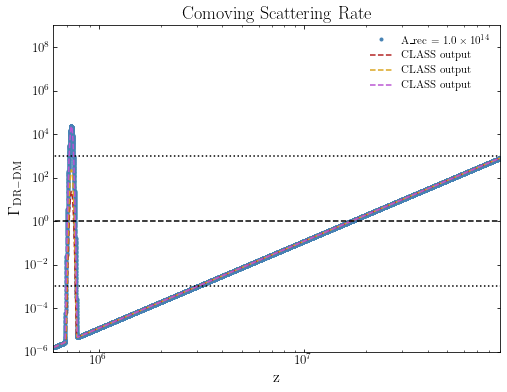

In [77]:
z_data = np.geomspace(1e-3,1e8,int(1e5))

# a_idm_dr = 3e5

plt.plot(z_data, my_dmu_idm_dr(z_data, A_recs[-1], T_rec=6e5, sigma_fac=0.01), '.', label='A_rec = {}'.format(scientific_format(A_recs[-1])))
# plt.plot(z_data, my_dmu_idm_dr(z_data, 0, a_idm_dr = a_idm_dr, T_rec=6e5, sigma_fac=0.01), '.', label='a_idm_dr = {}'.format(scientific_format(a_idm_dr)))


for i in range(len(A_recs)):
    plt.plot(z_data, kappa_dot_zs_arr[i](z_data), '--',label='CLASS output')

plt.plot([1e-3,1e10], [1,1], 'k--')
plt.plot([1e-3,1e10], [1e-3,1e-3], 'k:')
plt.plot([1e-3,1e10], [1e3,1e3], 'k:')

plt.xlim(6e5,9e7)
plt.ylim(1e-6,1e9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('z', fontsize=16)
plt.ylabel('$\Gamma_{\mathrm{DR-DM}}$', fontsize=16)
plt.title('Comoving Scattering Rate')
plt.legend()
plt.show()

## Matter Power Spectrum

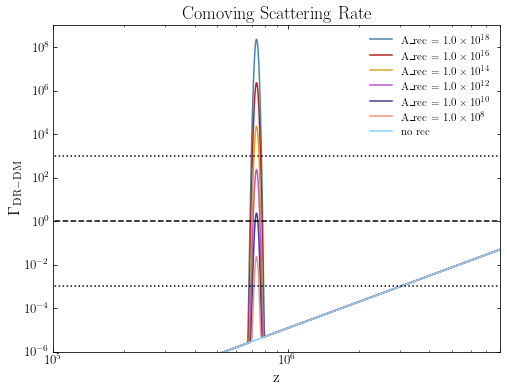

In [31]:
for i, A_rec in reversed(list(enumerate(A_recs))):
    plt.plot(z_arr[i], kappa_dot_zs_arr[i](z_arr[i]), label='A_rec = ' + scientific_format(A_rec))

plt.plot(z_data_no_rec, kappa_dot_data_no_rec, label='no rec ')

plt.plot([1e-3,1e10], [1,1], 'k--')
plt.plot([1e-3,1e10], [1e-3,1e-3], 'k:')
plt.plot([1e-3,1e10], [1e3,1e3], 'k:')

plt.xlim(1e5,8e6)
plt.ylim(1e-6,1e9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('z', fontsize=16)
plt.ylabel('$\Gamma_{\mathrm{DR-DM}}$', fontsize=16)
plt.title('Comoving Scattering Rate')
plt.legend()
plt.show()

In [40]:
Pk_fixed = [Pk_arr[i][390]/Pks_no_rec[390] for i in range(len(A_recs))]

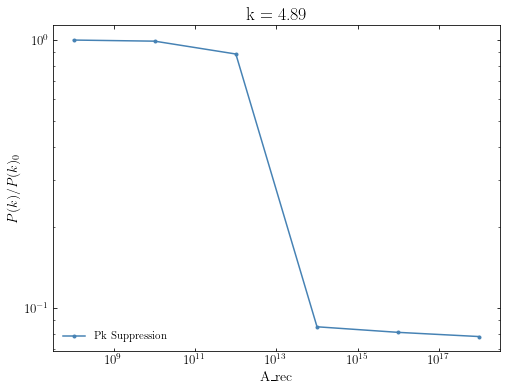

In [44]:
plt.loglog(A_recs,Pk_fixed, '.-', label='Pk Suppression')

plt.xlabel('A_rec')
plt.ylabel('$P(k)/P(k)_0$')
plt.title('k = {:.2f}'.format(kk[390]))

plt.legend(loc='lower left')


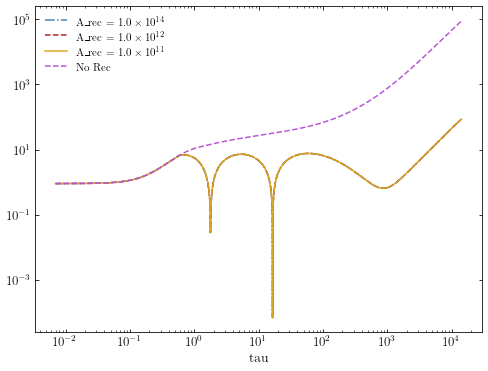

In [78]:
#k = 10
lines = ["-","--","-.",":"]
for i, A_rec in reversed(list(enumerate(A_recs))):
    plt.plot(tau_data, abs(delta_chi_data),  ls = lines[i%len(lines)], label='A_rec = ' + scientific_format(A_rec))

plt.plot(tau_data,abs(delta_chi_no_rec(tau_data)), '--', label='No Rec')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('tau')
# plt.ylabel('$delta chi$')
# plt.xlim(1,1e2)
plt.legend()
plt.show()

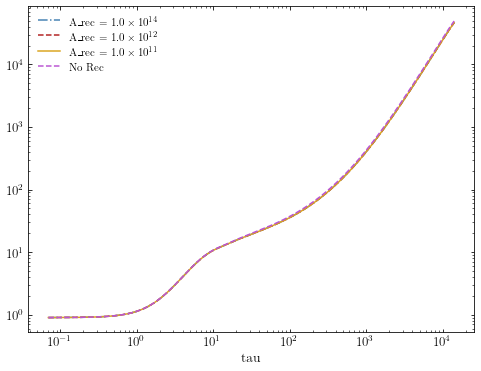

In [83]:
#k = 1
lines = ["-","--","-.",":"]
for i, A_rec in reversed(list(enumerate(A_recs))):
    plt.plot(tau_data, abs(delta_chi_data),  ls = lines[i%len(lines)], label='A_rec = ' + scientific_format(A_rec))

plt.plot(tau_data,abs(delta_chi_no_rec(tau_data)), '--', label='No Rec')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('tau')
# plt.ylabel('$delta chi$')
# plt.xlim(1,1e2)
plt.legend()
plt.show()

## Generate Data (shouldn't need to touch unless re-running CLASS)

In [85]:
from classy import Class

In [119]:
def getPk(classObj):
    kk = np.logspace(-4,np.log10(pk_max),500) # k in h/Mpc
    Pk = [] # P(k) in (Mpc/h)**3
    h = classObj.h() # get reduced Hubble for conversions to 1/Mpc
    for k in kk:
        Pk.append(classObj.pk(k*h,z_pk)*h**3) # function .pk(k,z)
    return Pk;

def getPkRatio(classObj1, classObj2):
    #Returns the ratio of the power spectrum of 1 to 2
    return[getPk(classObj1)[i]/getPk(classObj2)[i] for i in range(len(kk))]
    

def getdmu_idm_dr(classObj):
    return classObj.get_thermodynamics()['dmu_idm_dr']
    
def getzs(classObj):
    return classObj.get_thermodynamics()['z']

def getH(classObj):
    zs = np.flip(classObj.get_background()['z'])
    Hs = np.flip(classObj.get_background()['H [1/Mpc]'])
    return UnivariateSpline(zs, Hs, k=1.0, s=0.0)


def getDat(classObj):
    dmu_idm_dr = getdmu_idm_dr(classObj);
    zs = getzs(classObj)
    Hspline = getH(classObj)
    
    return dmu_idm_dr, zs, Hspline

# def my_dmu_idm_dr(z, A_rec, a_idm_dr = 1, Omega0_idm_dr = 0.12038, T_rec = 6.0e5, h =0.67556, xi_idr = 0.3 ):
#     base_rate = a_idm_dr * ((1+z)/(1e7))**4 * Omega0_idm_dr * h**2 

#     if T_rec >= (xi_idr * 2.73) * (1+z) and (xi_idr*2.73) * (1+z) > T_rec*0.99:
#         return base_rate*(1+A_rec)
#     else:
#         return base_rate

def save_class_obj(class_obj,A_rec):
    model = class_obj
    data_file=h5pydir+'class_testing_' +'%.2e'%A_rec+'.hdf5'
    with h5py.File(data_file, 'w') as f:    
        # Scalar group
        data = model.get_perturbations()['scalar']
        sub_group = f.create_group('scalar')
        for i, k in enumerate(BM_KS):
            sub_sub_group = sub_group.create_group(f'k={k}')
            d = data[i]
            for key, val in d.items():
                sub_sub_group.create_dataset(key, data=val)
        
        # Background group
        data = model.get_background()
        sub_group = f.create_group('background')
        for key, val in data.items():
            sub_group.create_dataset(key, data=val)
        
        # Thermo group
        data = model.get_thermodynamics()
        sub_group = f.create_group('thermodynamics')
        for key, val in data.items():
            sub_group.create_dataset(key, data=val)

        # Power Spectrum group
        data = getPk(model)
        sub_group = f.create_group('power_spectrum')
        sub_group.create_dataset('kk', data=kk)
        sub_group.create_dataset('Pk', data=data) 

         # CMB group
        data = model.lensed_cl(2500)
        sub_group = f.create_group('cmb')
        for key, val in data.items():
            sub_group.create_dataset(key, data=val)

In [ ]:
commonset = {
    'omega_b': 0.022032,
    'omega_cdm': omega0_cdm,
    'h': 0.67556,
    'A_s': 2.215e-9,
    'n_s': 0.9619,
    'tau_reio': 0.0925,
    'output': 'tCl,pCl,lCl,mPk',
    'lensing': 'yes',
    'P_k_max_1/Mpc': pk_max,
    'z_pk': 0.0,
    'k_output_values':",".join(BM_KS)
}

idrset = {
    # Dark matter/radiation parameters
    'f_idm_dr': f_idm_dr, #Amount of dm that is interacting
    'xi_idr': 0.3, 
    'stat_f_idr': 0.875, #fermionic
    'nindex_idm_dr': 4.0, 
    'm_idm': 1.0e3,
    # Scattering rate parameters
    'a_idm_dr': 1.0e0,
    'rec_case': 4, #1 = power, 2 = Theta, 3 = delta function, 4 = no recoupling 
}

single_late_set = {
    # Dark matter/radiation parameters
    'f_idm_dr': f_idm_dr, #Amount of dm that is interacting
    'xi_idr': 0.3, 
    'stat_f_idr': 0.875, #fermionic
    'nindex_idm_dr': 4.0, 
    'm_idm': 1.0e3,
    # Scattering rate parameters
    'a_idm_dr': 3e5,
    'rec_case': 4, #1 = power, 2 = Theta, 3 = delta function, 4 = no recoupling 
}

In [ ]:
sigma_fac = 0.01

for A_rec in A_recs:
    cos = Class()
    cos.set(commonset)
    cos.set(idrset)
    cos.set({
        'rec_case': 3,
        'A_rec':A_rec,
        'T_rec':T_rec,
        'sigma' : sigma_fac*T_rec #Gaussian width
        })
    cos.compute() 

    save_class_obj(cos,A_rec)
    
    # clear content of cos (to reuse it for another model)
    cos.struct_cleanup()
    # reset parameters to default
    cos.empty()

In [89]:
LambdaCDM = Class()
LambdaCDM.set(commonset)
LambdaCDM.compute()
LambdaCDMPk = getPk(LambdaCDM);

In [95]:
lensed_cls = LambdaCDM.lensed_cl(2500)
clTT = lensed_cls['tt']
ll = lensed_cls['ell']
clEE = lensed_cls['ee']
clPP = lensed_cls['pp']

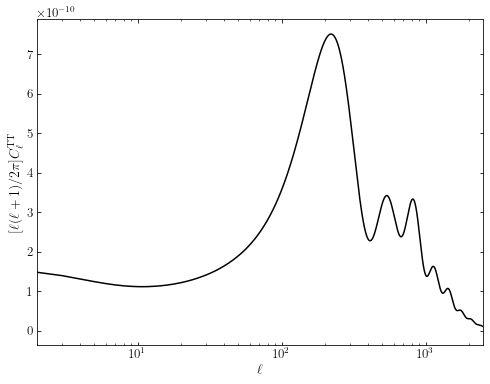

In [97]:
# plot C_l^TT
plt.xscale('log');plt.yscale('linear');plt.xlim(2,2500)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{TT}$')
plt.plot(ll,clTT*ll*(ll+1)/2./np.pi,'k-')

In [99]:
idrNoRec = Class()
idrNoRec.set(commonset)
idrNoRec.set(idrset)

idrNoRec.compute()

In [ ]:
idrNoRec_late = Class()
idrNoRec_late.set(commonset)
idrNoRec_late.set(single_late_set)

idrNoRec_late.compute()

In [100]:
model = idrNoRec
with h5py.File(h5pydir+'class_testing_no_rec.hdf5', 'w') as f:    
    # Scalar group
    data = model.get_perturbations()['scalar']
    sub_group = f.create_group('scalar')
    for i, k in enumerate(BM_KS):
        sub_sub_group = sub_group.create_group(f'k={k}')
        d = data[i]
        for key, val in d.items():
            sub_sub_group.create_dataset(key, data=val)
    
    # Background group
    data = model.get_background()
    sub_group = f.create_group('background')
    for key, val in data.items():
        sub_group.create_dataset(key, data=val)
    
    # Thermo group
    data = model.get_thermodynamics()
    sub_group = f.create_group('thermodynamics')
    for key, val in data.items():
        sub_group.create_dataset(key, data=val)

    # Power Spectrum group
    data = getPk(model)
    sub_group = f.create_group('power_spectrum')
    sub_group.create_dataset('kk', data=kk)
    sub_group.create_dataset('Pk', data=data) 

    # CMB group
    data = model.lensed_cl(2500)
    sub_group = f.create_group('cmb')
    for key, val in data.items():
        sub_group.create_dataset(key, data=val)

In [ ]:
model = idrNoRec_late
with h5py.File(h5pydir+'class_testing_no_rec_late.hdf5', 'w') as f:    
    # Scalar group
    data = model.get_perturbations()['scalar']
    sub_group = f.create_group('scalar')
    for i, k in enumerate(BM_KS):
        sub_sub_group = sub_group.create_group(f'k={k}')
        d = data[i]
        for key, val in d.items():
            sub_sub_group.create_dataset(key, data=val)
    
    # Background group
    data = model.get_background()
    sub_group = f.create_group('background')
    for key, val in data.items():
        sub_group.create_dataset(key, data=val)
    
    # Thermo group
    data = model.get_thermodynamics()
    sub_group = f.create_group('thermodynamics')
    for key, val in data.items():
        sub_group.create_dataset(key, data=val)

    # Power Spectrum group
    data = getPk(model)
    sub_group = f.create_group('power_spectrum')
    sub_group.create_dataset('kk', data=kk)
    sub_group.create_dataset('Pk', data=data) 

    # CMB group
    data = model.lensed_cl(2500)
    sub_group = f.create_group('cmb')
    for key, val in data.items():
        sub_group.create_dataset(key, data=val)

In [98]:
model = LambdaCDM
with h5py.File(h5pydir+'class_testing_LambdaCDM.hdf5', 'w') as f:    
    # Scalar group
    data = model.get_perturbations()['scalar']
    sub_group = f.create_group('scalar')
    for i, k in enumerate(BM_KS):
        sub_sub_group = sub_group.create_group(f'k={k}')
        d = data[i]
        for key, val in d.items():
            sub_sub_group.create_dataset(key, data=val)
    
    # Background group
    data = model.get_background()
    sub_group = f.create_group('background')
    for key, val in data.items():
        sub_group.create_dataset(key, data=val)
    
    # Thermo group
    data = model.get_thermodynamics()
    sub_group = f.create_group('thermodynamics')
    for key, val in data.items():
        sub_group.create_dataset(key, data=val)

    # Power Spectrum group
    data = getPk(model)
    sub_group = f.create_group('power_spectrum')
    sub_group.create_dataset('kk', data=kk)
    sub_group.create_dataset('Pk', data=data) 

    # CMB group
    data = model.lensed_cl(2500)
    sub_group = f.create_group('cmb')
    for key, val in data.items():
        sub_group.create_dataset(key, data=val)
    